In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import re
from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline, make_union, FeatureUnion
from sklearn_pandas import DataFrameMapper, cross_val_score, gen_features
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, FunctionTransformer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, make_scorer, f1_score, precision_score
from imblearn.over_sampling import SMOTE, RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pydotplus
%matplotlib inline
#For making API calls
import requests
from IPython.display import Image

Using TensorFlow backend.


# 1. Web Scrapping for Player Performance and Match Details

The dataset as provided was not fully extensive. Additional event required were time of matches and player seasonal performance. To obtain those information, **UiPath** was use to scrape the website https://www.iplt20.com/

The following were scrapped from the website:
1. Player Performance in Total Runs made from 2008 to 2019
2. Player Performance in Total Wickets made from 2008 to 2019
3. Time that each matches occured

### Player Performance

With the performance for each player captured, we need to make sure that these names corresponds to those that were available in the kaggle dataset. As the kaggle dataset had names being truncated, it was not suitable for the API calls (which required fullnames). Hence:
1. Scrape players list were used in API calls
2. Scrape players were used to match with kaggle dataset, which also links to API player list

### Match Details

As we are also looking into weater attributes and the impact on a match, we need the time and location of each mact to use a weather api to pull weather conditions. From kaggle dataset we had match dates and the playing teams. Using that we could match it with the scraped data whihc contained the date, playing teams and the time.

## 1.1 API - Collecting Player Attributes

With the initial datasets, we only have the players fullnames. To get the player special attributes, we used the api from cricapi.com.However, attributes can only be called by using the website's assigned pid to each player.

Hence to have them all come together, we first have to:
1. Breakdown player names from initial dataset and break them first name and lastname (List 1)
2. Using List 1, make an api call to pull associated player pid (List 2)
3. Using List 2, make an api call to pull player attributes (List 3)
4. Associate List 3 with initial dataset

In [ ]:
# Get Players from the scrape dataset
w_total_wickets = pd.read_csv("Datasets/new-ipl-data/w_total_wickets.csv")
# Get a series of players by name
w_names = (w_total_wickets["PLAYER"].append(w_total_runs["PLAYER"])).unique().tolist()

# Get only the surnames
w_surnames = []

for name in w_names:
    surname = name.split()
    w_surnames.append(surname[-1])

#Get only the unique players
w_surnames_unique = list(set(w_surnames))

### Using the player list, loop through each player to get their pid

In [ ]:
pid = []
fullname = []
name_list = []

for name in w_surnames_unique:
    response = requests.get("https://cricapi.com/api/playerFinder?apikey=4PwcAidmcfgF4rHins5Z8V2XxPx1&name="+name).json()
    
    for i in range(0, len(response['data'])):
        pid.append(response['data'][i]['pid'])
        fullname.append(response['data'][i]['fullName'])
        name_list.append(response['data'][i]['name'])

df_player = pd.DataFrame(list(zip(pid, fullname, name_list)), 
       columns =['pid', 'fullname', 'name']) 

In [ ]:
##Some manual intervention is needed, hence we export it to correct them
df_player.to_csv("player_pid_profile")

### Using the player list with pid, use the api again to pull the player attribute

In [ ]:
df_player_full = pd.read_csv("web-players-2.csv", usecols=["Player","pid"])

pid_list = []
born = []
battingStyle = []
bowlingStyle = []
playingRole = []

for pid in df_player_full["pid"]:
    response = requests.get("https://cricapi.com/api/playerStats?apikey=4PwcAidmcfgF4rHins5Z8V2XxPx1&pid="+str(pid)).json()
    
    pid_list.append(response['pid'])
    born.append(response['born'])
    battingStyle.append(response['battingStyle'])
    bowlingStyle.append(response['bowlingStyle'])
    playingRole.append(response['playingRole'])

##Some manual intervention is needed, hence we export it to correct them    
df_player_full = pd.DataFrame(list(zip(pid_list, born, battingStyle, bowlingStyle, playingRole)), 
               columns =['pid', 'born', 'battingStyle', 'bowlingStyle', 'playingRole']) 

df_player_full.to_csv("player_pid_profile_full.csv")

## 1.2 API - Collecting Weather Information

The initial datasets noly had venues of the matches. Some manual work needed to be done to associate these venues with the longtitude and latitude. With the initial datascrapping, we had the exact time of the match. With these information, we could use the api and associate weather condition to each match

In [ ]:
matches = pd.read_csv("matches_test.csv")

### Using the matches list, loop through each match to get their weather condition

In [ ]:
temperature = []
apparentTemperature = []
dewPoint = []
humidity = []
pressure = []
windSpeed = []
windBearing = []
cloudCover = []
uvIndex = []

for index, row in matches.iterrows():
    response = requests.get("https://api.darksky.net/forecast/1c469943840fa5f5f7da8719884fcfda/"+str(matches["latitude"][index])+","+str(matches["longtitude"][index])+","+str(matches["start_time_unix"][index])+"?exclude=currently,minutely,flags&units=si").json()
    
    if matches["day_game_no"][index] == 1:
        j = 10
        try:
            try:
                temperature.append(response["hourly"]["data"][j]["temperature"])
            except KeyError:
                temperature.append("NA")
            try:
                apparentTemperature.append(response["hourly"]["data"][j]["apparentTemperature"])
            except KeyError:
                apparentTemperature.append("NA")
            try:
                dewPoint.append(response["hourly"]["data"][j]["dewPoint"])
            except KeyError:
                dewPoint.append("NA")
            try:
                humidity.append(response["hourly"]["data"][j]["humidity"])
            except KeyError:
                humidity.append("NA")
            try:
                pressure.append(response["hourly"]["data"][j]["pressure"])
            except KeyError:
                pressure.append("NA")
            try:
                windSpeed.append(response["hourly"]["data"][j]["windSpeed"])
            except KeyError:
                windSpeed.append("NA")
            try:
                windBearing.append(response["hourly"]["data"][j]["windBearing"])
            except KeyError:
                windBearing.append("NA")
            try:
                cloudCover.append(response["hourly"]["data"][j]["cloudCover"])
            except KeyError:
                cloudCover.append("NA")
            try:
                uvIndex.append(response["hourly"]["data"][j]["uvIndex"])
            except KeyError:
                uvIndex.append("NA")
        except IndexError:
            j = -1
        except KeyError:
            temperature.append("NA")
            apparentTemperature.append("NA")          
            dewPoint.append("NA")           
            humidity.append("NA")           
            pressure.append("NA")           
            windSpeed.append("NA")           
            windBearing.append("NA")          
            cloudCover.append("NA")
            uvIndex.append("NA")     
    else:
        j = 14
        try:
            try:
                temperature.append(response["hourly"]["data"][j]["temperature"])
            except KeyError:
                temperature.append("NA")
            try:
                apparentTemperature.append(response["hourly"]["data"][j]["apparentTemperature"])
            except KeyError:
                apparentTemperature.append("NA")
            try:
                dewPoint.append(response["hourly"]["data"][j]["dewPoint"])
            except KeyError:
                dewPoint.append("NA")
            try:
                humidity.append(response["hourly"]["data"][j]["humidity"])
            except KeyError:
                humidity.append("NA")
            try:
                pressure.append(response["hourly"]["data"][j]["pressure"])
            except KeyError:
                pressure.append("NA")
            try:
                windSpeed.append(response["hourly"]["data"][j]["windSpeed"])
            except KeyError:
                windSpeed.append("NA")
            try:
                windBearing.append(response["hourly"]["data"][j]["windBearing"])
            except KeyError:
                windBearing.append("NA")
            try:
                cloudCover.append(response["hourly"]["data"][j]["cloudCover"])
            except KeyError:
                cloudCover.append("NA")
            try:
                uvIndex.append(response["hourly"]["data"][j]["uvIndex"])
            except KeyError:
                uvIndex.append("NA")
        except IndexError:
            j = -1
        except KeyError:
            temperature.append("NA")
            apparentTemperature.append("NA")          
            dewPoint.append("NA")           
            humidity.append("NA")           
            pressure.append("NA")           
            windSpeed.append("NA")           
            windBearing.append("NA")          
            cloudCover.append("NA")
            uvIndex.append("NA")

In [ ]:
#export weather the details with macthes
df_matches_weather = pd.DataFrame(list(zip(temperature,
                                           apparentTemperature,
                                           dewPoint,
                                           humidity,
                                           pressure,
                                           windSpeed,
                                           windBearing,
                                           cloudCover,
                                           uvIndex
                                           )), 
               columns =['temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed', 'windBearing', 'cloudCover', 'uvIndex']) 

df_matches_weather.to_csv("matches_v3.csv")

# 2. Data Preprocessing

With all the data collected, we need to link them together and export it to a flat table for further analysis. We also drop columns which we find are not important. The data as collected can be summarised below:

![title](data_overview.png)

In [2]:
# Load all collected data and mapping table
deliveries = pd.read_csv('Data Set Final/deliveries.csv')
matching_kaggle = pd.read_csv('Data Set Final/dataset_link.csv')
matches = pd.read_csv('Data Set Final/matches_v2.csv')
players = pd.read_csv('Data Set Final/player_pid_profile_full.csv')
matching_IPL = pd.read_csv('Data Set Final/dataset_link_IPL.csv')
run_stats = pd.read_csv('Data Set Final/w_total_runs.csv')
wicket_stats = pd.read_csv('Data Set Final/w_total_wickets.csv')

In [3]:
len(deliveries)

179078

In [4]:
#dropping unneccessary columns
deliveries = deliveries.drop(columns=['is_super_over', 'wide_runs', 'bye_runs', 'legbye_runs',
                                      'noball_runs', 'penalty_runs','total_runs', 'extra_runs',
                                      'player_dismissed','dismissal_kind', 'fielder'])

In [5]:
#dropping unnecessary columns
matches = matches.drop(columns=['player_of_match', 'dl_applied', 'result','winner', 'win_by_runs', 'umpire1',
                                'win_by_wickets', 'date', 'umpire2', 'umpire3', 'venue', 'apparentTemperature',
                               'team1', 'team2', 'toss_winner'])

#dropping columns with too many NAs
matches = matches.drop(columns=['pressure'])
di = {'field': 0, 'bat': 1}
matches['toss_decision'] = matches['toss_decision'].map(di)

In [6]:
#extracting the birth year for all players and discarding birth day and birth place
players['born'] = players['born'].str.split(',',expand=True)[1].astype(int)

di = {'Left-hand bat': 0, 'Right-hand bat': 1}
players['battingStyle'] = players['battingStyle'].map(di)

players['bowlingStyle'] = players['bowlingStyle'].apply(lambda x: str(x).lower())
strings = ['googly', 'left-arm', 'right-arm', 'offbreak', 'legbreak', 'fast', 'medium', 'slow']

def manip(input_str):
    try:
        x = s in input_str
        return int(x)
    except TypeError:
        return int(0)

for s in strings:
    players['bstyle_%s'%s] = players['bowlingStyle'].apply(lambda x: manip(x))
    
players = players.drop(columns=['bowlingStyle', 'playingRole'])
players = players.rename(columns={'pid': 'player_id'})

In [7]:
run_stats.columns

run_stats['HS_star'] = run_stats['HS'].map(lambda x: x.__contains__('*')).astype(int)
run_stats['HS'] = run_stats['HS'].map(lambda x: re.split(r'[^\w]+',str(x))).map(lambda x: x[0]).astype(int)

run_stats.head()

,POS,PLAYER,Mat,Inns,NO,Runs,HS,Avg,BF,SR,100,50,4s,6s,Year,HS_star
0,1,Shaun Marsh,11,11,2,616,115,68.44,441,139.68,1,5,59,26,2008,0
1,2,Gautam Gambhir,14,14,1,534,86,41.07,379,140.89,0,5,68,8,2008,0
2,3,Sanath Jayasuriya,14,14,2,518,114,43.16,309,167.63,1,2,58,31,2008,1
3,4,Shane Watson,15,15,5,472,76,47.20,311,151.76,0,4,47,19,2008,1
4,5,Graeme Smith,11,11,2,441,91,49.00,362,121.82,0,3,54,8,2008,0


In [8]:
#merging the player stats with player id and player names
matching_kaggle = matching_kaggle.merge(players, on='player_id')

#different available player types in the dataset
player_types = ['batsman', 'non_striker', 'bowler']

#deliveries as the base file for all merges
merged_file = deliveries

#do a left join for the respective match information for all deliveries -- weather data missing
merged_file = merged_file.merge(matches, left_on='match_id', right_on='id', how='left').drop(columns='id')

#looping over different player and merge on player name
for p in player_types:
    merged_file = merged_file.merge(matching_kaggle, left_on= p, right_on='player_name', how='left').drop(columns='player_name')
    merged_file = merged_file.rename(columns={'player_id': '%s_id'%p,
                                              'born': '%s_born'%p,
                                              'battingStyle': '%s_battingStyle'%p,
                                              'bstyle_googly': '%s_bstyle_googly'%p,
                                              'bstyle_left-arm': '%s_bstyle_left-arm'%p,
                                              'bstyle_right-arm': '%s_bstyle_right-arm'%p,
                                              'bstyle_offbreak': '%s_bstyle_offbreak'%p,
                                              'bstyle_legbreak': '%s_bstyle_legbreak'%p,
                                              'bstyle_fast': '%s_bstyle_fast'%p,
                                              'bstyle_medium': '%s_bstyle_medium'%p,
                                              'bstyle_slow': '%s_bstyle_slow'%p})

In [9]:
col_to_drop = ['batsman', 'non_striker', 'bowler', 'batsman_bstyle_googly',
               'batsman_bstyle_left-arm', 'batsman_bstyle_right-arm','batsman_bstyle_offbreak',
               'batsman_bstyle_legbreak', 'batsman_bstyle_fast', 'batsman_bstyle_medium',
               'batsman_bstyle_slow', 'non_striker_battingStyle', 
               'non_striker_bstyle_googly', 'non_striker_bstyle_left-arm', 'non_striker_bstyle_right-arm',
               'non_striker_bstyle_offbreak', 'non_striker_bstyle_legbreak', 'non_striker_bstyle_fast', 
               'non_striker_bstyle_medium', 'non_striker_bstyle_slow','bowler_battingStyle']  
merged_file = merged_file.drop(columns=col_to_drop)

In [10]:
#making the player id the main key for the run stats file
run_stats = run_stats.merge(matching_IPL, left_on='PLAYER', right_on='player_name').drop(columns=['player_name', 'POS','PLAYER'])

#making the player id the main key for the wicket stats file
wicket_stats = wicket_stats.merge(matching_IPL, left_on='PLAYER', right_on='player_name').drop(columns=['player_name', 'POS','PLAYER'])

In [11]:
wicket_columns = ['Mat', 'Inns', 'Ov', 'Runs', 'Wkts', 'BBI', 'Avg', 'Econ', 'SR', '4w', '5w']
#creating lag of 1 year
wicket_stats['Year'] = wicket_stats['Year']-1

merged_file = merged_file.merge(wicket_stats, left_on=['bowler_id','season'], right_on=['player_id','Year'], how='left').drop(columns=['player_id','Year'])
for w in wicket_columns:
    merged_file = merged_file.rename(columns={w: '%s_wicket'%w})
    
run_columns = ['Mat', 'Inns', 'NO', 'Runs', 'HS', 'Avg', 'BF', 'SR', '100', '50', '4s', '6s', 'Year', 'player_id']

In [12]:
#creating lag of 1 year
run_stats['Year'] = run_stats['Year']-1

In [13]:
merged_file = merged_file.merge(run_stats, left_on=['batsman_id','season'], right_on=['player_id','Year'], how='left').drop(columns=['player_id','Year'])
for r in run_columns:
    merged_file = merged_file.rename(columns={r: '%s_run'%r})

#dropping player IDs after all merges done
merged_file = merged_file.drop(columns=['batsman_id', 'non_striker_id', 'bowler_id'])

In [14]:
merged_file['batsman_runs'].unique()

array([0, 4, 1, 6, 3, 2, 5, 7])

In [15]:
#3, 5 and 7 are very rare outcomes and do not happen in normal games
#hence grouped together with the closest possible score
merged_file.loc[merged_file.batsman_runs == 3, 'batsman_runs'] = 4
merged_file.loc[merged_file.batsman_runs == 5, 'batsman_runs'] = 6
merged_file.loc[merged_file.batsman_runs == 7, 'batsman_runs'] = 6

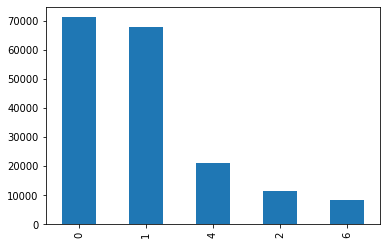

In [16]:
%matplotlib inline
merged_file['batsman_runs'].value_counts().plot(kind='bar')

### Dropping Unnecessary Columns 
dewpoint, uvIndex: not helpful for predicting ball result

BBI_wicket: only has 0 value, so drop 

In [17]:
merged_file = merged_file.drop(['dewPoint', 'uvIndex', 'BBI_wicket'], axis=1)
merged_file.shape

(179667, 50)

## Data Imputation

In [18]:
#An additional indicator is created if there are no player statistics available for a given player in a year

wicket_cols = ['Mat_wicket', 'Inns_wicket', 'Ov_wicket', 'Runs_wicket', 'Wkts_wicket', 'Avg_wicket', 'Econ_wicket', 'SR_wicket', '4w_wicket', '5w_wicket']
merged_file['wicket_na'] = merged_file[wicket_cols].isnull().apply(lambda x: all(x), axis=1).astype(int)

run_cols = ['Mat_run', 'Inns_run', 'NO_run', 'Runs_run', 'HS_run', 'Avg_run', 'BF_run', 'SR_run', '100_run',
            '50_run', '4s_run', '6s_run', 'HS_star']
merged_file['run_na'] = merged_file[run_cols].isnull().apply(lambda x: all(x), axis=1).astype(int)

In [19]:
#The assumption here is that if the statistics are missing, it is highly likely due to the player is not famous or new. 
#Thus their skill should not be that good, thus use 25 quantile. 

player_stats = ['Mat_wicket', 'Inns_wicket', 'Ov_wicket', 'Runs_wicket', 'Wkts_wicket',
                'Avg_wicket', 'Econ_wicket', 'SR_wicket', '4w_wicket', '5w_wicket', 'Mat_run', 'Inns_run',
                'NO_run', 'Runs_run', 'HS_run', 'Avg_run', 'BF_run', 'SR_run', '100_run', '50_run', 
                '4s_run', '6s_run', 'HS_star']

merged_file[player_stats] = merged_file[player_stats].transform(lambda x: x.fillna(x.quantile(.25)))

In [20]:
merged_file = merged_file.dropna()

In [21]:
len(merged_file)

143278

### End of Preprocessing

# 3. Feature Engineering

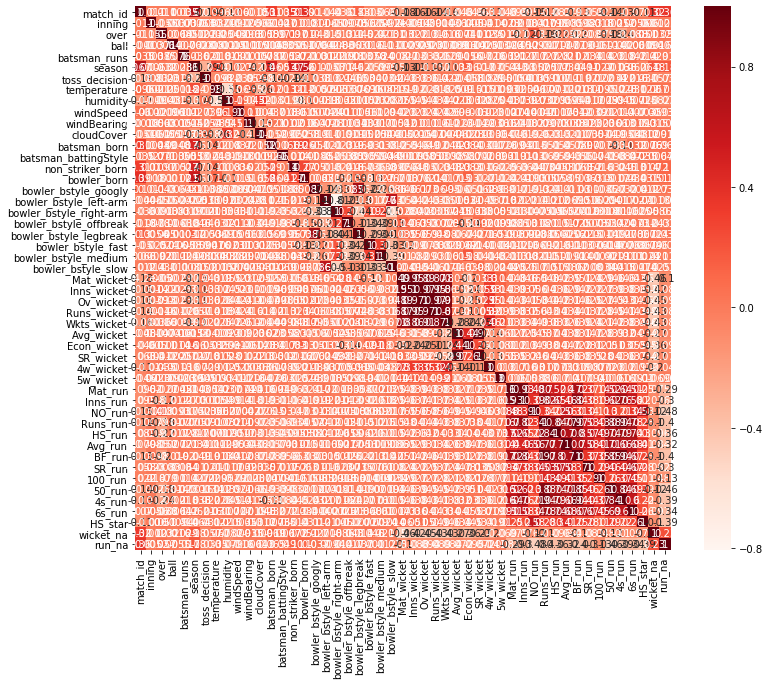

In [22]:
plt.figure(figsize=(12,10))
sns.heatmap(merged_file.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

In [24]:
header=list(merged_file.corr().columns.values)

for i in header:
    cor_target = abs(merged_file.corr()[i])
    cor_df=pd.DataFrame(cor_target)
    cor_df=cor_df.drop([i], axis=0)
    relevant_features = cor_df[cor_df[i]>0.8]
    if relevant_features.shape[0]>=1:
        display(relevant_features)

,bowler_bstyle_left-arm
bowler_bstyle_right-arm,0.805746


,bowler_bstyle_right-arm
bowler_bstyle_left-arm,0.805746


,Mat_wicket
Inns_wicket,0.948174
Ov_wicket,0.890416
Runs_wicket,0.868140


,Inns_wicket
Mat_wicket,0.948174
Ov_wicket,0.968294
Runs_wicket,0.951285
Wkts_wicket,0.864308


,Ov_wicket
Mat_wicket,0.890416
Inns_wicket,0.968294
Runs_wicket,0.969575
Wkts_wicket,0.905031


,Runs_wicket
Mat_wicket,0.868140
Inns_wicket,0.951285
Ov_wicket,0.969575
Wkts_wicket,0.868108


,Wkts_wicket
Inns_wicket,0.864308
Ov_wicket,0.905031
Runs_wicket,0.868108


,Avg_wicket
SR_wicket,0.966043


,SR_wicket
Avg_wicket,0.966043


,Mat_run
Inns_run,0.927679


,Inns_run
Mat_run,0.927679
Runs_run,0.817357
BF_run,0.844093


,Runs_run
Inns_run,0.817357
HS_run,0.843590
BF_run,0.973134
50_run,0.883227
4s_run,0.942016


,HS_run
Runs_run,0.84359


,BF_run
Inns_run,0.844093
Runs_run,0.973134
50_run,0.854714
4s_run,0.939839


,50_run
Runs_run,0.883227
BF_run,0.854714
4s_run,0.843498


,4s_run
Runs_run,0.942016
BF_run,0.939839
50_run,0.843498


### Data Observation

From the correlation map, we found serveral paris that are highly correlated. 

1. 'Mat_wicket','Inns_wicket','Ov_wicket','Runs_wicket','Wkts_wicket': highly correlated. will apply pca to form one parameter
2. 'Mat_run', 'Inns_run',  'Runs_run', 'HS_run', 'Avg_run', 'BF_run', '50_run', '4s_run', '6s_run': highly correlated, will perform pca also


Check the detailed correlation first cluster: 'Mat_wicket','Inns_wicket','Ov_wicket','Runs_wicket','Wkts_wicket'

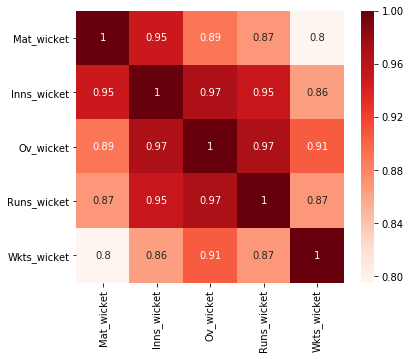

In [22]:
wicket_cols = ['Mat_wicket','Inns_wicket','Ov_wicket','Runs_wicket','Wkts_wicket']
plt.figure(figsize=(6,5))
sns.heatmap(merged_file[wicket_cols].corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

Instead of selecting one column and delete to the rest to deal with multiple-colinearity, we decided to use PCA method to combine high correalation columns into one column to reduce dimensionality while preserving variance. This will be done later as part of the modeling pipeline

Perform pca for second big highly correlated cluster: 'Mat_run', 'Inns_run', 'Runs_run', 'HS_run', 'Avg_run', 'BF_run', '50_run', '4s_run', '6s_run'

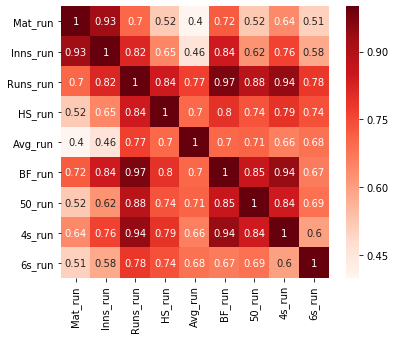

In [23]:
run_cols = ['Mat_run', 'Inns_run',  'Runs_run', 'HS_run', 'Avg_run', 'BF_run', '50_run', '4s_run', '6s_run']
plt.figure(figsize=(6,5))
sns.heatmap(merged_file[run_cols].corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

In [24]:
merged_file.dtypes
integers = ['HS_star', 'batsman_battingStyle', 'bowler_bstyle_googly', 'bowler_bstyle_left-arm', 
          'bowler_bstyle_right-arm', 'bowler_bstyle_offbreak', 'bowler_bstyle_legbreak', 'bowler_bstyle_fast',
          'bowler_bstyle_medium', 'bowler_bstyle_slow', '100_run', '50_run', 'Runs_run', 'HS_run', 'BF_run',
           '4s_run', '6s_run', '5w_wicket', '4w_wicket', 'NO_run']
merged_file[integers] = merged_file[integers].astype(int)

In [25]:
#Teams can be categorized into different tiers based on their public perception

teams = {'Sunrisers Hyderabad' : 1, 'Royal Challengers Bangalore': 1, 'Mumbai Indians': 0,
         'Rising Pune Supergiant': 2, 'Gujarat Lions': 2, 'Kolkata Knight Riders': 0,
         'Kings XI Punjab': 1, 'Delhi Daredevils': 1, 'Chennai Super Kings': 0,
         'Deccan Chargers': 2, 'Rajasthan Royals': 2, 'Kochi Tuskers Kerala': 2,
         'Pune Warriors': 2, 'Rising Pune Supergiants': 2, 'Delhi Capitals': 1}

merged_file['batting_tier'] = merged_file['batting_team'].map(teams)
merged_file['bowling_tier'] = merged_file['bowling_team'].map(teams)

In [26]:
#A new indicator is created based on if the batting or bowling team is playing in their hometown.
#Playing in the hometown could lead to additional support of spectators and higher motivation

hometown = {'Sunrisers Hyderabad': 'Hyderabad', 'Royal Challengers Bangalore': 'Bangalore', 'Mumbai Indians': 'Mumbai',
           'Rising Pune Supergiant': 'Pune', 'Gujarat Lions': None, 'Kolkata Knight Riders': 'Kolkata',
           'Kings XI Punjab': 'Mohali', 'Delhi Daredevils': 'Delhi', 'Chennai Super Kings': 'Chennai',
           'Deccan Chargers': 'Hyderabad', 'Rajasthan Royals': 'Jaipur', 'Kochi Tuskers Kerala': 'Kochi',
           'Pune Warriors': 'Pune', 'Rising Pune Supergiants': 'Pune'}

merged_file['bowling_home'] = (merged_file['bowling_team'].map(hometown) == merged_file['city']).astype(int)
merged_file['batting_home'] = (merged_file['batting_team'].map(hometown) == merged_file['city']).astype(int)

In [27]:
print(merged_file.shape)

(143278, 56)


In [28]:
y = merged_file.batsman_runs
X = merged_file.drop(columns=['batsman_runs'])

In [29]:
#Select and transform the needed columns with a DataFrameMapper

mapper = DataFrameMapper([
    (['inning'], None),
    (['over'], None),
    (['ball'], None),
    (['season'], None),
    (['toss_decision'], None),
    (['temperature'], None),
    (['humidity'], None),
    (['windSpeed'], None),
    (['windBearing'], None),
    (['cloudCover'], None),
    (['batsman_born'], None),
    (['batsman_battingStyle'], None),
    (['non_striker_born'], None),
    (['bowler_born'], None),
    (['bowler_bstyle_googly'], None),(['bowler_bstyle_left-arm'], None),(['bowler_bstyle_right-arm'], None),(['bowler_bstyle_offbreak'], None),
    (['bowler_bstyle_legbreak'], None),(['bowler_bstyle_fast'], None),(['bowler_bstyle_medium'], None),(['bowler_bstyle_slow'], None),
    (['Avg_wicket'], None),
    (['Econ_wicket'], None),
    (['4w_wicket'], None),
    (['5w_wicket'], None),
    (['NO_run'], None),
    (['SR_run'], None),
    (['100_run'], None),
    (['HS_star'], None),
    (['batting_tier'], OneHotEncoder(handle_unknown='ignore'), {'alias': 'batting_tier'}),
    (['bowling_tier'], OneHotEncoder(handle_unknown='ignore'), {'alias': 'bowling_tier'}),
    (['batting_home'], None),
    (['bowling_home'], None),
    (wicket_cols, make_pipeline(StandardScaler(), PCA(1)), {'alias': 'wicket_cols'}),
    (run_cols, make_pipeline(StandardScaler(), PCA(3)), {'alias': 'run_cols'}),
    (['run_na'], None),
    (['wicket_na'], None),
])

In [30]:
X_map = mapper.fit_transform(X)
X_map.shape

(143278, 44)

### Creating New Features based on original dataset

In [31]:
def relative_mat(X):
    return X['Mat_run']/X['Mat_wicket']
rel_mat = FunctionTransformer(lambda x: x.apply(relative_mat, axis=1).to_numpy().reshape(-1,1))

def relative_inns(X):
    return X['Inns_run']/X['Inns_wicket']
rel_inns = FunctionTransformer(lambda x: x.apply(relative_inns, axis=1).to_numpy().reshape(-1,1))

def relative_runs(X):
    return X['Runs_run']/X['Runs_wicket']
rel_runs = FunctionTransformer(lambda x: x.apply(relative_runs, axis=1).to_numpy().reshape(-1,1))

def relative_avg(X):   
    return X['Avg_run']/X['Avg_wicket']
rel_avg = FunctionTransformer(lambda x: x.apply(relative_avg, axis=1).to_numpy().reshape(-1,1))

def relative_sr(X):    
    return X['SR_run']/X['SR_wicket']
rel_sr = FunctionTransformer(lambda x: x.apply(relative_sr, axis=1).to_numpy().reshape(-1,1))

In [32]:
all_features = FeatureUnion([('mapper', mapper), ('rel_mat', rel_mat), ('rel_inns', rel_inns),
                             ('rel_runs', rel_runs), ('rel_avg', rel_avg), ('rel_sr', rel_sr)])

In [33]:
#Create DataFrame with all variables used in the classifiers below:

X_map = mapper.fit_transform(X)
cols = mapper.transformed_names_
cols.append('rel_mat')
cols.append('rel_inns')
cols.append('rel_runs')
cols.append('rel_avg')
cols.append('rel_sr')

# 4. Modelling
### Grouping of outcomes to more significant groupings

In [34]:
#In order to achieve the goal to distinguish between a significant and non-significant event, a score above 1
#was chosen to be significant while a 0 and 1 is a non-significant score
#combine batsman_runs score of 2, 4, 6 to 2

y_gr = y.copy()
y_gr[y_gr == 1] = 0
y_gr[y_gr == 2] = 1
y_gr[y_gr == 4] = 1
y_gr[y_gr == 6] = 1

### Train Test Split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y_gr, test_size=0.2, random_state = 42)

### Define Model Objective

In [62]:
#Since the class imbalance is high, the overall objective of the model should not be to simply maximize accuracy
#as this could lead to only one class being selected. The objective function of the GridSearchCV therefore has to
#be modified in order to maximize over the macro average of the respective F1 scores of the 2 groups
score1 = make_scorer(f1_score, average='macro')


#We also tried maximizing the precision score only for the group 1 but this then leads to an extremely low support
#and therefore there are almost no true positives anymore. This is therefore discarded
score2 = make_scorer(precision_score, average='binary', pos_label=1)


#The best results for the given goal were obtained using the f1 score for only the class 1 label since this is
#maximizing the true positive while also minimizing any false negatives
score3 = make_scorer(f1_score, average='binary', pos_label=1)

### Sampling Datasets

In order to have a balanced dataset, we decide to apply a few sampling techniques:
1. Random Over Sampling
2. Random Under Sampling
3. SMOTE

Use Logistic Regression as the baseline model, we will see whether sampling techniques can help increase accuracy! 

### SMOTE

In [101]:
pipe = Pipeline([
    ('featurize', all_features),
    #('feature_selection', SelectFromModel(LogisticRegression(C=1, penalty='l2'))),
    ('sampler', SMOTE(random_state=42)),
    ('lm', LogisticRegression())])

param_grid = {
    'lm__C': np.logspace(-4, 4, 4),
}
log_reg_smote = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=2, scoring=score3)
log_reg_smote.fit(X_train, y_train)
print("CV scores for best parameters (CV score=%0.5f):" % log_reg_smote.best_score_)
predicted_lr_smote = log_reg_smote.predict(X_test)
print('See below the classification report based on Test data')
print(classification_report(y_test, predicted_lr_smote))

CV scores for best parameters (CV score=0.34282):
See below the classification report based on Test data
              precision    recall  f1-score   support

           0       0.79      0.54      0.64     22102
           1       0.25      0.53      0.34      6554

    accuracy                           0.54     28656
   macro avg       0.52      0.53      0.49     28656
weighted avg       0.67      0.54      0.57     28656



### Random Over Sampling

In [102]:
pipe = Pipeline([
    ('featurize', all_features),
    ('sc', StandardScaler()),
    #('feature_selection', SelectFromModel(LogisticRegression(C=1, penalty='l2'))),
    ('sampler', RandomOverSampler(random_state = 42)),
    ('lm', LogisticRegression())])

param_grid = {
    'lm__C': np.logspace(-4, 4, 4),
}
log_reg_ros = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=2, scoring=score3)
log_reg_ros.fit(X_train, y_train)
print("CV scores for best parameters (CV score=%0.5f):" % log_reg_ros.best_score_)
predicted_lr_ros = log_reg_ros.predict(X_test)
print('See below the classification report based on Test data')
print(classification_report(y_test, predicted_lr_ros))

CV scores for best parameters (CV score=0.34731):
See below the classification report based on Test data
              precision    recall  f1-score   support

           0       0.80      0.55      0.65     22102
           1       0.26      0.53      0.35      6554

    accuracy                           0.55     28656
   macro avg       0.53      0.54      0.50     28656
weighted avg       0.68      0.55      0.58     28656



### Random Under Sampling

In [103]:
pipe = Pipeline([
    ('featurize', all_features),
    ('scaling', StandardScaler()),
    #('feature_selection', SelectFromModel(LogisticRegression(C=1, penalty='l2'))),
    ('sampler', RandomUnderSampler(random_state = 42)),
    ('lm', LogisticRegression())])

param_grid = {
    'lm__C': np.logspace(-4, 4, 4),
}
log_reg_rus = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=2, scoring=score3)
log_reg_rus.fit(X_train, y_train)
print("CV scores for best parameters (CV score=%0.5f):" % log_reg_rus.best_score_)

predicted_lr_rus = log_reg_rus.predict(X_test)
print('See below the classification report based on Test data')
print(classification_report(y_test, predicted_lr_rus))

CV scores for best parameters (CV score=0.34797):
See below the classification report based on Test data
              precision    recall  f1-score   support

           0       0.80      0.55      0.65     22102
           1       0.26      0.54      0.35      6554

    accuracy                           0.55     28656
   macro avg       0.53      0.55      0.50     28656
weighted avg       0.68      0.55      0.58     28656



### Combination of SMOTE and Undersampling

In [104]:
pipe = Pipeline([
    ('featurize', all_features),
    ('scaling', StandardScaler()),
    ('over', SMOTE(random_state=42)),
    ('under', RandomUnderSampler(random_state=42)),
    ('lm', LogisticRegression())])

param_grid = {
    'lm__C': np.logspace(-4, 4, 4),
    'over__sampling_strategy': [0.6, 0.7, 0.8, 0.9],
    'under__sampling_strategy': [0.6, 0.7, 0.8, 0.9]
}



log_reg_comb = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=2, verbose=2, scoring=score3)
%time log_reg_comb.fit(X_train, y_train)
print("CV scores for best parameters (CV score=%0.5f):" % log_reg_comb.best_score_)
predicted_lr_comb = log_reg_comb.predict(X_test)
print('See below the classification report based on Test data')
print(classification_report(y_test, predicted_lr_comb))

Fitting 2 folds for each of 64 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed: 36.7min finished


CPU times: user 1min 53s, sys: 2.16 s, total: 1min 55s
Wall time: 38min 31s
CV scores for best parameters (CV score=0.31633):
See below the classification report based on Test data
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     22102
           1       0.28      0.38      0.32      6554

    accuracy                           0.64     28656
   macro avg       0.54      0.54      0.54     28656
weighted avg       0.68      0.64      0.65     28656



In [105]:
print('Best parameters: ', log_reg_comb.best_params_)

Best parameters:  {'lm__C': 10000.0, 'over__sampling_strategy': 0.7, 'under__sampling_strategy': 0.9}


The best sampling strategy by far is the combination of SMOTE and Undersampling with a sampling strategy dependent on the classifier. Combining the two samplers yields in the highest macro average of F1 scores while at the same time increasing accuracy by more than 30%.

This is applied to more advanced models now and the sampling strategies are determined for each model individually

## Basic Models 

## 5.1 KNN

In [160]:
pipe = Pipeline([
    ('featurize', all_features),
    ('scaler', StandardScaler()),
    #('feature_selection', SelectFromModel(LogisticRegression(C=1, penalty='l2'))),
    ('over', SMOTE(random_state=42)),
    ('under', RandomUnderSampler(random_state=42)),   
    ('knn', KNeighborsClassifier(n_jobs=-1))])

param_grid = {
    'over__sampling_strategy': [0.9], #[0.6, 0.7, 0.8, 0.9],
    'under__sampling_strategy': [0.9], #[0.6, 0.7, 0.8, 0.9],
    'knn__n_neighbors': [11] #np.arange(8, 12)
}

knn = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=2, verbose=2, scoring=score3)
%time knn.fit(X_train, y_train)

print("CV scores for best parameters (CV score=%0.5f):" % knn.best_score_)
print('Best parameters: ', knn.best_params_)
print('Train Accuracy :', knn.best_estimator_.score(X_train, y_train))

predicted_knn = knn.best_estimator_.predict(X_test)
print('See below the classification report based on Test data')
print(classification_report(y_test, predicted_knn))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 11.1min finished


CPU times: user 2min 31s, sys: 1.93 s, total: 2min 33s
Wall time: 13min 39s
CV scores for best parameters (CV score=0.33623):
Best parameters:  {'knn__n_neighbors': 11, 'over__sampling_strategy': 0.9, 'under__sampling_strategy': 0.9}
Train Accuracy : 0.6556507476749664
See below the classification report based on Test data
              precision    recall  f1-score   support

           0       0.79      0.55      0.65     22102
           1       0.25      0.51      0.34      6554

    accuracy                           0.54     28656
   macro avg       0.52      0.53      0.49     28656
weighted avg       0.67      0.54      0.58     28656



## 5.2 Logistic Regression

In [65]:
pipe = Pipeline([
    ('featurize', all_features),
    ('scaling', StandardScaler()),
    ('over', SMOTE(random_state=42)),
    ('under', RandomUnderSampler(random_state=42)),
    ('lm', LogisticRegression())])

param_grid = {
    'lm__C': [10000], #[1, 100, 500, 1000,10000], #np.logspace(-4, 4, 4),
    'over__sampling_strategy': [0.7], #[0.6, 0.7, 0.8, 0.9],
    'under__sampling_strategy': [0.9] #[0.6, 0.7, 0.8, 0.9]
}



log_reg = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=2, verbose=2, scoring=score3)
%time log_reg.fit(X_train, y_train)
print("CV scores for best parameters (CV score=%0.5f):" % log_reg.best_score_)
print('Best parameters: ', log_reg.best_params_)
predicted_lr = log_reg.predict(X_test)
print('See below the classification report based on Test data')
print(classification_report(y_test, predicted_lr))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   38.3s finished


CPU times: user 1min 42s, sys: 1.11 s, total: 1min 43s
Wall time: 2min 20s
CV scores for best parameters (CV score=0.31580):
Best parameters:  {'lm__C': 10000, 'over__sampling_strategy': 0.9, 'under__sampling_strategy': 0.9}
See below the classification report based on Test data
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     22102
           1       0.28      0.38      0.32      6554

    accuracy                           0.63     28656
   macro avg       0.54      0.55      0.54     28656
weighted avg       0.68      0.63      0.65     28656



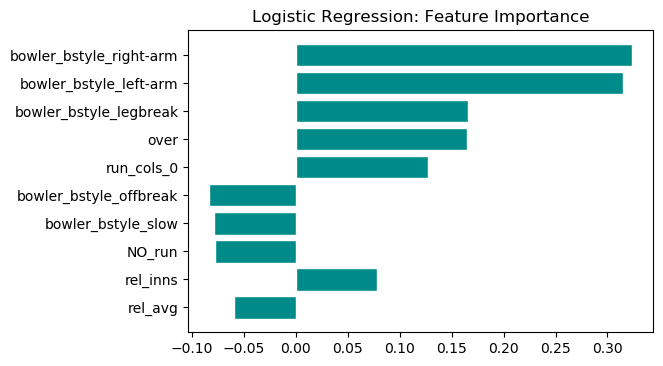

In [106]:
coefs=[]
for coef0 in log_reg.best_estimator_['lm'].coef_[0]:
    coefs.append(coef0)

features_LR=[]
for feature in cols:
    features_LR.append(feature)
coef={'feature':features_LR,'coef':coefs}
feature_coef=DataFrame(coef,index=None)
feature_coef['abs'] = abs (feature_coef.coef)
importances_lr = feature_coef.sort_values(by='abs', ascending=True)
importances_lr = importances_lr.iloc[-10:]
plt.figure(figsize = (6,4),dpi = 100)
plt.barh(importances_lr['feature'], importances_lr['coef'], label='Coef' ,facecolor = '#008B8B', edgecolor = 'white')
plt.title('Logistic Regression: Feature Importance')
plt.show()

## 5.3 Decision Tree

In [107]:
pipe = Pipeline([
    ('featurize', all_features),
    ('scaler', StandardScaler()),
    #('feature_selection', SelectFromModel(LogisticRegression(C=1, penalty='l2'))),
    ('over', SMOTE(random_state=42)),
    ('under', RandomUnderSampler(random_state=42)),
    ('dt', DecisionTreeClassifier())])

param_grid ={
    'over__sampling_strategy': [0.9], #[0.6, 0.7, 0.8, 0.9],
    'under__sampling_strategy': [0.9], #[0.6, 0.7, 0.8, 0.9],
    'dt__max_depth': [5], #[5, 6, 7, 8, 9], 
    'dt__min_samples_leaf': [150], #[70, 75, 80, 90, 100, 150]
}

#calling pipeline with gridsearch
dt = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=2, verbose = 3, scoring=score3)
%time dt.fit(X_train, y_train)

print("CV scores for best parameters (CV score=%0.5f):" % dt.best_score_)
print('Best parameters: ',dt.best_params_)
print('Train Accuracy :', dt.best_estimator_.score(X_train, y_train))

predicted_dt = dt.best_estimator_.predict(X_test)
print('See below the classification report based on Test data')
print(classification_report(y_test, predicted_dt))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   48.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   48.0s finished


CPU times: user 1min 50s, sys: 1.48 s, total: 1min 51s
Wall time: 2min 41s
CV scores for best parameters (CV score=0.32190):
Best parameters:  {'dt__max_depth': 5, 'dt__min_samples_leaf': 150, 'over__sampling_strategy': 0.9, 'under__sampling_strategy': 0.9}
Train Accuracy : 0.49551569506726456
See below the classification report based on Test data
              precision    recall  f1-score   support

           0       0.77      0.48      0.59     22102
           1       0.23      0.52      0.32      6554

    accuracy                           0.49     28656
   macro avg       0.50      0.50      0.45     28656
weighted avg       0.65      0.49      0.53     28656



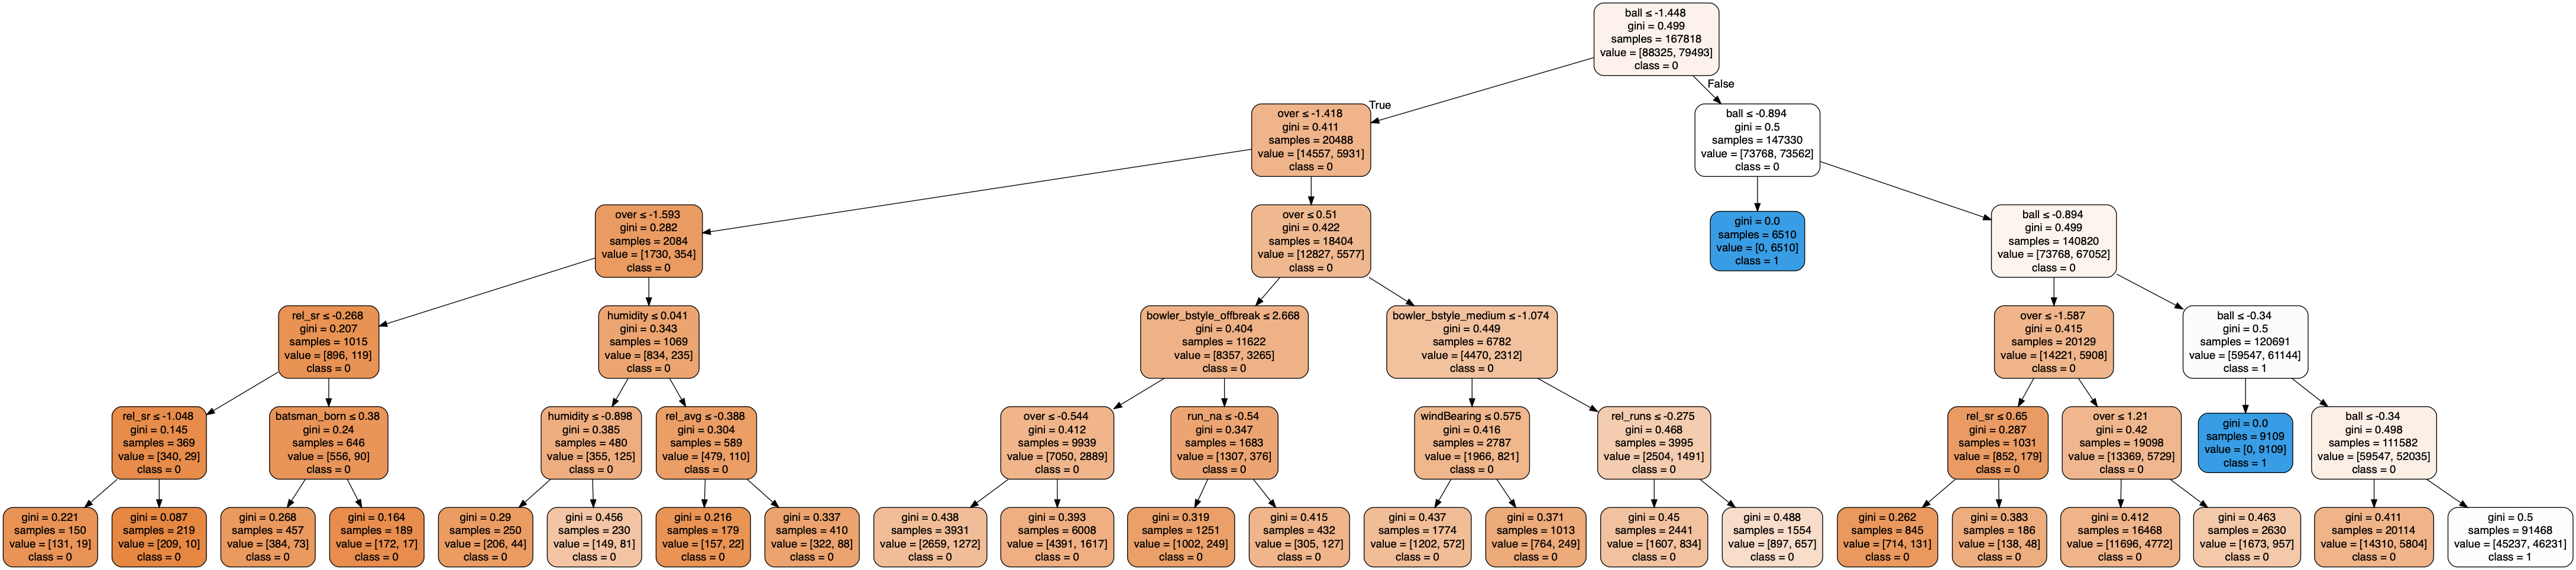

In [108]:
dot_data = StringIO()

export_graphviz(dt.best_estimator_['dt'], out_file=dot_data, 
                feature_names = cols,
                class_names= ['0','1'],
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Ensemble Models 

## 5.3 LightGBM

#### With ROS and RUS combined

In [109]:
pipe = Pipeline([
    ('featurize', all_features),
    ('scaler', StandardScaler()),
    #('feature_selection', SelectFromModel(LogisticRegression(C=1, penalty='l2'))),
    ('over', RandomOverSampler(random_state=42)),
    ('under', RandomUnderSampler(random_state=42)),
    ('lgb', LGBMClassifier(random_state=42))])

param_grid ={
    'over__sampling_strategy': [0.6, 0.7, 0.8, 0.9],
    'under__sampling_strategy': [0.6, 0.7, 0.8, 0.9],
    'lgb__n_estimators': [50, 100, 200, 300, 1000],
    'lgb__min_child_weight': [100], #[1e-2, 1e-1, 1, 1e1, 1e2],
    'lgb__max_depth': [16], #[4, 8, 16, 32],
    'lgb__learning_rate': [0.1, 0.05, 0.001, 0.0001]
}


#calling pipeline with gridsearch
lgb = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=2, verbose = 3, scoring=score3)
%time lgb.fit(X_train, y_train)

print("CV scores for best parameters (CV score=%0.5f):" % lgb.best_score_)
print('Best parameters: ',lgb.best_params_)
print('Train Accuracy :', lgb.best_estimator_.score(X_train, y_train))

predicted_lgb = lgb.best_estimator_.predict(X_test)
print('See below the classification report based on Test data')
print(classification_report(y_test, predicted_lgb))

Fitting 2 folds for each of 320 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 77.6min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 188.2min finished


CPU times: user 2min 19s, sys: 7.72 s, total: 2min 27s
Wall time: 3h 9min 24s
CV scores for best parameters (CV score=0.32707):
Best parameters:  {'lgb__learning_rate': 0.05, 'lgb__max_depth': 16, 'lgb__min_child_weight': 100, 'lgb__n_estimators': 200, 'over__sampling_strategy': 0.6, 'under__sampling_strategy': 0.9}
Train Accuracy : 0.6828183071312662
See below the classification report based on Test data
              precision    recall  f1-score   support

           0       0.80      0.73      0.76     22102
           1       0.30      0.40      0.34      6554

    accuracy                           0.65     28656
   macro avg       0.55      0.56      0.55     28656
weighted avg       0.69      0.65      0.67     28656



#### With SMOTE and RUS combined

In [161]:
pipe = Pipeline([
    ('featurize', all_features),
    ('scaler', StandardScaler()),
    #('feature_selection', SelectFromModel(LogisticRegression(C=1, penalty='l2'))),
    ('over', SMOTE(random_state=42)),
    ('under', RandomUnderSampler(random_state=42)),
    ('lgb', LGBMClassifier(random_state=42))])

param_grid ={
    'over__sampling_strategy': [0.6], #[0.6, 0.7, 0.8, 0.9],
    'under__sampling_strategy': [0.9], #[0.6, 0.7, 0.8, 0.9],
    'lgb__n_estimators': [1000], #[50, 100, 200, 300, 1000],
    'lgb__min_child_weight': [100] ,#[1e-2, 1e-1, 1, 1e1, 1e2],
    'lgb__max_depth': [16], #[4, 8, 16, 32, 64],
    'lgb__learning_rate': [0.1] #[0.1, 0.05, 0.001, 0.0001]
}


#calling pipeline with gridsearch
lgb2 = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=2, verbose = 3, scoring=score3)
%time lgb2.fit(X_train, y_train)

print("CV scores for best parameters (CV score=%0.5f):" % lgb2.best_score_)
print('Best parameters: ',lgb2.best_params_)
print('Train Accuracy :', lgb2.best_estimator_.score(X_train, y_train))

predicted_lgb2 = lgb2.best_estimator_.predict(X_test)
print('See below the classification report based on Test data')
print(classification_report(y_test, predicted_lgb2))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.4min finished


CPU times: user 2min 47s, sys: 1.34 s, total: 2min 48s
Wall time: 3min 19s
CV scores for best parameters (CV score=0.22737):
Best parameters:  {'lgb__learning_rate': 0.1, 'lgb__max_depth': 16, 'lgb__min_child_weight': 100, 'lgb__n_estimators': 1000, 'over__sampling_strategy': 0.6, 'under__sampling_strategy': 0.9}
Train Accuracy : 0.7970197693287502
See below the classification report based on Test data
              precision    recall  f1-score   support

           0       0.78      0.92      0.84     22102
           1       0.32      0.13      0.18      6554

    accuracy                           0.74     28656
   macro avg       0.55      0.52      0.51     28656
weighted avg       0.68      0.74      0.69     28656



SMOTE and RUS give a higher accuracy but combined with a slightly lower macro average of F1-scores compared to ROS and RUS. For now, both models are kept and the decision will be made in the final model evaluation

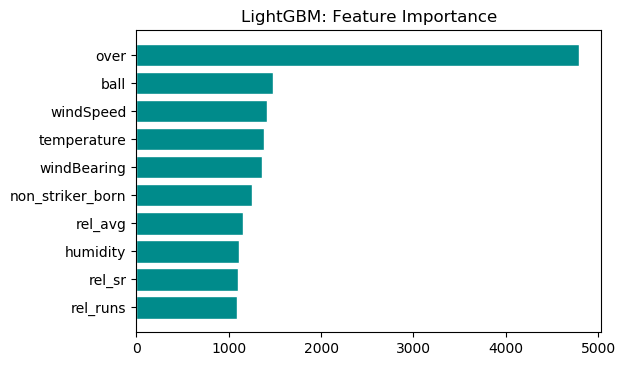

In [162]:
importances_lgb = lgb2.best_estimator_['lgb'].feature_importances_
feature_importances_lgb = DataFrame({'feature':features_LR,'importance':importances_lgb},index=None)
importances_lgb =feature_importances_lgb.sort_values(by='importance', ascending=True)
importances_lgb =importances_lgb.iloc[-10:]

plt.figure(figsize = (6,4),dpi = 100)
plt.barh(importances_lgb['feature'], importances_lgb['importance'], label='Importance' ,facecolor = '#008B8B', edgecolor = 'white')
plt.title('LightGBM: Feature Importance')
plt.show()

## 5.4 Random Forest

In [87]:
pipe = Pipeline([
    ('featurize', all_features),
    ('scaler', StandardScaler()),
    #('feature_selection', SelectFromModel(LogisticRegression(C=1, penalty='l2'))),
    ('over', SMOTE(random_state=42)),
    ('under', RandomUnderSampler(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))])

param_grid ={
    'over__sampling_strategy': [0.6, 0.7, 0.8, 0.9],
    'under__sampling_strategy': [0.6, 0.7, 0.8, 0.9],
    'rf__max_depth': [9],#range(2,10)
    'rf__min_samples_split': [10], #[10, 12, 14, 16],
    'rf__n_estimators': [4, 8, 16, 32, 64]
}

#calling pipeline with gridsearch
rf = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=2, verbose = 4, scoring=score3)
%time rf.fit(X_train, y_train)

print("CV scores for best parameters (CV score=%0.5f):" % rf.best_score_)
print('Best parameters: ',rf.best_params_)
print('Train Accuracy :', rf.best_estimator_.score(X_train, y_train))

predicted_rf = rf.best_estimator_.predict(X_test)
print('See below the classification report based on Test data')
print(classification_report(y_test, predicted_rf))


Fitting 2 folds for each of 80 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 45.6min finished


CPU times: user 1min 44s, sys: 2.14 s, total: 1min 46s
Wall time: 47min 11s
CV scores for best parameters (CV score=0.26868):
Best parameters:  {'over__sampling_strategy': 0.6, 'rf__max_depth': 9, 'rf__min_samples_split': 10, 'rf__n_estimators': 4, 'under__sampling_strategy': 0.9}
Train Accuracy : 0.676196541676118
See below the classification report based on Test data
              precision    recall  f1-score   support

           0       0.78      0.78      0.78     22102
           1       0.26      0.27      0.26      6554

    accuracy                           0.66     28656
   macro avg       0.52      0.52      0.52     28656
weighted avg       0.66      0.66      0.66     28656



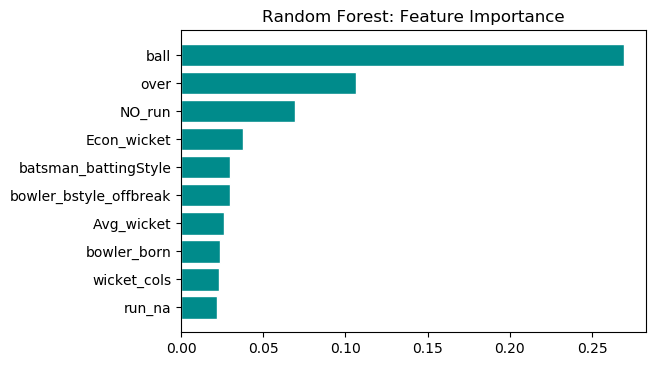

In [163]:
importances_rf = rf.best_estimator_['rf'].feature_importances_
feature_importances_rf=pd.DataFrame({'feature':cols,'importance':importances_rf},index=None)
importances_rf =feature_importances_rf.sort_values(by='importance', ascending=True)
importances_rf =importances_rf.iloc[-10:]

plt.figure(figsize = (6,4),dpi = 100)
plt.barh(importances_rf['feature'], importances_rf['importance'], label='Importance' ,facecolor = '#008B8B', edgecolor = 'white')
plt.title('Random Forest: Feature Importance')
plt.show()

## 5.5 Neural Network 

In [149]:
# baseline model
def create_model():
    model = Sequential()
    model.add(Dense(60, input_dim=all_features.fit_transform(X_train).shape[1], activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

clf = KerasClassifier(build_fn=create_model, epochs=15, batch_size=64)    

pipe = Pipeline([
    ('featurize', all_features),
    ('scaler', StandardScaler()),
    ('over', SMOTE(random_state=42)),
    ('under', RandomUnderSampler(random_state=42)),
    ('clf', clf),
])

param_grid = {
    'over__sampling_strategy': [0.6, 0.7, 0.8, 0.9],
    'under__sampling_strategy': [0.6, 0.7, 0.8, 0.9],
}

nn = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=2, verbose=3, scoring=score3)

nn.fit(X_train, y_train)
print("CV scores for best parameters (CV score=%0.5f):" % nn.best_score_)
print('Best parameters: ',nn.best_params_)
print('Train Accuracy :', nn.best_estimator_.score(X_train, y_train))

predicted_nn = nn.best_estimator_.predict(X_test)
print('See below the classification report based on Train data')
print(classification_report(y_test, predicted_nn))

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed: 19.8min finished







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/15
111878/111878 [==============================] - 5s 44us/step - loss: 0.6869 - acc: 0.5443
Epoch 2/15
111878/111878 [==============================] - 4s 36us/step - loss: 0.6795 - acc: 0.5686
Epoch 3/15
111878/111878 [==============================] - 4s 36us/step - loss: 0.6720 - acc: 0.5835
Epoch 4/15
111878/111878 [==============================] - 4s 36us/step - loss: 0.6650 - acc: 0.5969
Epoch 5/15
111878/111878 [==============================] - 4s 37us/step - loss: 0.6577 - acc: 0.6106
Epoch 6/15
111878/111878 [==============================] - 4s 36us/step - loss: 0.6510 - acc: 0.6202
Epoch 7/15
111878/111878 [==============================] - 4s 37us/step - loss: 0.6441 - acc: 0.6288
Epoch 8/15
111878/111878 [==============================] - 4s 36us/step - loss: 0.6383 - acc: 0.6381
Epoch 9/15
111878/111878 [==============================] - 4s 36us/step - loss: 0.6

## 5.6 Random Guess

In [251]:
predict_random = {
    "rand": np.random.binomial(1, (y_train.value_counts()[1] / y_train.value_counts()[0]), 114622)
}
predict_random_test = {
    "rand": np.random.binomial(1, (y_train.value_counts()[1] / y_train.value_counts()[0]), 28656)
}

# Final Model Selection with Profit Maximization

In [249]:
predict_dict = {
    "LR_SMOTE": log_reg_smote.best_estimator_.predict_proba(X_train)[:, 1],
    "LR_ROS": log_reg_ros.best_estimator_.predict_proba(X_train)[:, 1],
    "LR_RUS": log_reg_rus.best_estimator_.predict_proba(X_train)[:, 1],
    "KNN": knn.best_estimator_.predict_proba(X_train)[:, 1],
    "LR": log_reg.best_estimator_.predict_proba(X_train)[:, 1],
    "DT": dt.best_estimator_.predict_proba(X_train)[:, 1],
    "LGB1": lgb.best_estimator_.predict_proba(X_train)[:, 1],
    "LGB2": lgb2.best_estimator_.predict_proba(X_train)[:, 1],
    "RF": rf.best_estimator_.predict_proba(X_train)[:, 1],
    "NN": nn.best_estimator_.predict_proba(X_train)[:, 1]
}

def cost_function(y_actual, predict_dict, cost, revenue, low_thres = 0.25, high_thres = 0.75):
    cost_function_output = pd.DataFrame()
    best_profit = float('-inf')
    best_model = None
    best_threshold = None
    for i in predict_dict:
        for threshold in np.arange(low_thres, high_thres, 0.01):
            confusion_out = confusion_matrix(y_actual, np.where(predict_dict[i] > threshold,1,0))
            t_cost = (confusion_out[1][1] + confusion_out[0][1]) * cost
            t_revenue = confusion_out[0][1] * 0.7 + confusion_out[1][1] * revenue
            profit = t_revenue-t_cost
            if profit > best_profit:
                best_profit = profit
                best_model = i
                best_threshold = threshold
                
    
    return best_profit, best_model, best_threshold



In [277]:
bp, bm, bt = cost_function(y_train, predict_dict, 1, 1.4)
bp_rand,_ ,_ = cost_function(y_train, predict_random, 1, 1.4)

In [278]:
print('The best model is',bm, 'with a threshold of', round(bt,2), 'and generates a marginal profit of', round((bp/114622)-(bp_rand/114622),4)*100, '% per ad slot compared to a random guess')

The best model is LGB2 with a threshold of 0.45 and generates a marginal profit of 5.82 % per ad slot compared to a random guess


In [260]:
lgb2.estimator.set_params(**lgb2.best_params_).fit(X_train, y_train)
prediction_dict ={'prediction' :np.where(lgb2.predict_proba(X_test)[:, 1] > bt,1,0)}
bp_pred,_ ,_ = cost_function(y_test, prediction_dict, 1, 1.4)
bp_rand_t,_ ,_ = cost_function(y_test, predict_random_test, 1, 1.4)

In [266]:
print('The marginal profit of',bm,'on the test set is',round((bp_pred/28656-bp_rand_t/28656),4)*100,'% per ad slot compared to a random guess!! $$$$$$')

The marginal profit of LGB2 on the test set is 2.88 % per ad slot compared to a random guess!! $$$$$$


![title](joey4.png)